In [1]:
import os
import math
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.contrib import rnn
from util.CalcReturns import CalcReturns

In [2]:
def recurrent_neural_network_model(input):

    layer = {'w' : tf.Variable(tf.random_normal([num_hidden, n_classes])),
             'b' : tf.Variable(tf.random_normal([n_classes]))}
    
    input = tf.unstack(input, timesteps, 1)    
    
    lstm_cell = rnn.BasicLSTMCell(num_hidden)    
    outs, state = rnn.static_rnn(lstm_cell, input, dtype=tf.float32)
    
    output = tf.add(tf.matmul(outs[-1], layer['w']), layer['b'], name='nn')    
    return output

def train_and_save_nn(x_data,y_data):
    x_train = tf.placeholder('float', [None, timesteps, num_input], name='x')
    y_train = tf.placeholder('float', [None, n_classes], name='y')
    
    nn = recurrent_neural_network_model(x_train)
    cost = tf.reduce_mean(tf.abs(tf.subtract(nn, y_train)), name='cost')    
    #optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.01).minimize(cost)   
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(cost)   
    
    correct = tf.equal(tf.argmax(nn,1), tf.argmax(y_train, 1), name='correct')
    accuracy = tf.reduce_mean(tf.cast(correct, 'float'), name = 'accuracy')
    
    saver = tf.train.Saver()
    
    with tf.Session() as session:
        
        session.run(tf.initialize_all_variables())
        
        epoch_loss = 0
        for epoch in range(hm_epochs):
            epoch_loss = 0
            for i in range(int(len(X_train)/batch_size)):
                
                batch_x = x_data[i*batch_size : (i+1)*batch_size]
                batch_y = y_data[i*batch_size : (i+1)*batch_size]
               
                batch_x = batch_x.reshape((batch_size, timesteps, num_input))
                
                _, c = session.run([optimizer, cost], feed_dict = {x_train: batch_x, y_train: batch_y})
                epoch_loss += c
                
            if epoch % 10 == 0:
                print('Epoch', epoch, 'completed out of', hm_epochs, 'loss', epoch_loss)
               
        saver.save(session, 'data/fxrn.ckpt')        
        print('Last epoch loss: ', epoch_loss)
        
    return nn, correct, accuracy

def test_nn(x_test, y_test):
    with tf.Session() as session:
        saver = tf.train.import_meta_graph('data/fxrn.ckpt.meta')
        saver.restore(session, tf.train.latest_checkpoint('data/'))
        
        graph    = tf.get_default_graph()        
                
        x  = graph.get_tensor_by_name('x:0')        
        nn = graph.get_tensor_by_name('nn:0')        

        inputs  = x_test        
        inputs  = np.reshape(inputs, (testsize, 1, 1))
        
        outputs = session.run([nn], feed_dict = {x: inputs})
        predicted = outputs[0]        

        # Visualising the results        
        plt.plot(x_test,    color = 'green', label = 'Input')
        plt.plot(y_test,    color = 'blue',  label = 'Actual')
        plt.plot(predicted, color = 'red',   label = 'Predicted')

        plt.title('Google Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Google Stock Price')
        plt.legend()
        plt.show()

In [3]:
timesteps  = 1
num_input  = 1
n_classes  = 1
step       = num_input * timesteps

lag        = 1
testsize   = 16
trainsize  = 1024 + 256

hm_epochs  = 200
num_hidden = 160
batch_size = 32

In [4]:
# Feature Scaling
from sklearn.preprocessing import MinMaxScaler
sc = MinMaxScaler()

# Importing the training set
data_set = pd.read_csv('EURUSD1.csv')
data_set = data_set[:trainsize + lag + testsize + lag + 1]

data_set = data_set.iloc[:,1:2].values

returns = np.reshape(CalcReturns(data_set), (trainsize + lag + testsize + lag,1))
returns = sc.fit_transform(returns)

testing_set  = returns[-testsize-lag:]
training_set = returns[:trainsize+lag]

# Getting the inputs and the ouputs
X_train = training_set[0:trainsize]
Y_train = training_set[lag:trainsize+lag]

X_test = testing_set[0:testsize]
Y_test = testing_set[lag:testsize+lag]

# Reshaping
X_train = np.reshape(X_train, (trainsize, 1, 1))

In [5]:
train_and_save_nn(X_train, Y_train)

Tensor("rnn/gru_cell/add:0", shape=(?, 160), dtype=float32)
Tensor("rnn/gru_cell/add:0", shape=(?, 160), dtype=float32)
Instructions for updating:
Use `tf.global_variables_initializer` instead.
('Epoch', 0, 'completed out of', 200, 'loss', 4.5343495421111584)
('Epoch', 10, 'completed out of', 200, 'loss', 2.2414660640060902)
('Epoch', 20, 'completed out of', 200, 'loss', 2.2505715982988477)
('Epoch', 30, 'completed out of', 200, 'loss', 2.2547235451638699)
('Epoch', 40, 'completed out of', 200, 'loss', 2.2499190764501691)
('Epoch', 50, 'completed out of', 200, 'loss', 2.2422870490700006)
('Epoch', 60, 'completed out of', 200, 'loss', 2.2539908075705171)
('Epoch', 70, 'completed out of', 200, 'loss', 2.2738083377480507)
('Epoch', 80, 'completed out of', 200, 'loss', 2.2412879914045334)
('Epoch', 90, 'completed out of', 200, 'loss', 2.2566858492791653)
('Epoch', 100, 'completed out of', 200, 'loss', 2.2403692556545138)
('Epoch', 110, 'completed out of', 200, 'loss', 2.2634610440582037)
(

(<tf.Tensor 'nn:0' shape=(?, 1) dtype=float32>,
 <tf.Tensor 'correct:0' shape=(?,) dtype=bool>,
 <tf.Tensor 'accuracy:0' shape=() dtype=float32>)

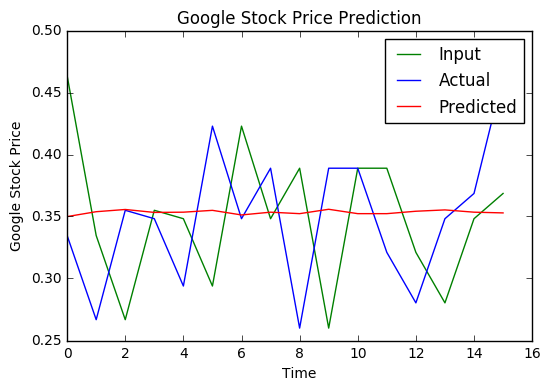

In [6]:
test_nn(X_test, Y_test)
